<h1>Applied Data Science Capstone Project</h1>

<h2> Berlin venues and the spread of the coronavirus - are there types of urban structures that increase the risk of infections? </h2>

While covid- cases rise sharply in the second wave everywhere in Berlin, some parts of the city are still more affected than others. Is there a particular reason why the virus is spreading faster in certain districts than in others? 
In this investigation, Berlin districts were clustered based on their venue infrastructure and placed in the context of Covid case numbers. The aim was to analyze whether a certain constellation of places where people come together may have an influence on the infection figures in this region.

<h1>PART 1: Clustering the districts of Berlin according to their venue offer</h1>

The first task was to determine the specific types of venues offered by the individual districts of Berlin and how the city can be clustered on the basis of these similarities between the various districts. 

<h2>Preparation of the data analysis</h2>

In the first step all necessary libraries will be imported. 

In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             import numpy as np 
import pandas as pd 
import json 

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

!conda install beautifulsoup4 --yes
from bs4 import BeautifulSoup 

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    pkgs/main::ca-certificates-2020.12.8-~ --> conda-forge::ca-certificates-2020.12.5-ha878542_0
  certifi            pkgs/main::certifi-2020.12.5-py36h06a~ --> conda-forge::certifi-2020.12.5-py36h5fab9bb_0
  openssl              pkgs/main::openssl-1.1.1i-h27cfd23_0 --> conda-forge::openssl-1.1.1i-h7f98852_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - beautifulsoup4


The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2020.12.~ --> pkgs/main::ca-certificates-2020.12.8

<h2> Importing the data set with Berlin districts </h2> 

The table was scraped from Wikipedia using an html-parser for conversion into a pandas data frame

In [70]:
#data = "https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins"
data = requests.get('https://de.wikipedia.org/wiki/Verwaltungsgliederung_Berlins').text
#soup_berlin = bs(urlopen(html_doc_berlin), 'html.parser')
soup_berlin = BeautifulSoup(data, 'html.parser')

In [71]:
table = soup_berlin.findAll('table', attrs={'class':'wikitable sortable zebra'})[1]

table_heads = table.find_all('th')    
cols = [table.text for table in table_heads]
cols = [i.strip() for i in cols]

table_rows = table.find_all('tr')

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    row = [i.strip() for i in row]
    l.append(row)
borough_berlin_df = pd.DataFrame(l, columns=cols)
borough_berlin_df.head(4)

,Nr.,Ortsteil,Bezirk,Fläche(km²),Einwohner[2](31. Dezember 2019),Einwohnerpro km²
0,None,None,None,None,None,None
1,0101,Mitte,Mitte,"10,70",102.465,9576
2,0102,Moabit,Mitte,"7,72",80.495,10.427
3,0103,Hansaviertel,Mitte,"0,53",5.926,11.181


Making a copy of the dataset in its original shape as we will need it later

In [72]:
berlin_boroughs = borough_berlin_df.copy()

Reducing the data to the column we'll need

In [5]:
cols = [0,2,3,4,5]
borough_berlin_df.drop(borough_berlin_df.columns[cols],axis=1,inplace=True)

borough_berlin_df.columns = ['district']

borough_berlin_df

,district
0,None
1,Mitte
2,Moabit
3,Hansaviertel
4,Tiergarten
...,...
93,Waidmannslust
94,Lübars
95,Wittenau
96,Märkisches Viertel


Dropping missing values

In [6]:
berlin_df_dropna = borough_berlin_df[borough_berlin_df.district.notnull()]
berlin_df_dropna.head()

,district
1,Mitte
2,Moabit
3,Hansaviertel
4,Tiergarten
5,Wedding


<h2>Getting the geo data</h2>

Installing geocoder from geopy to obtain geospatial data of Berlin

In [7]:
!pip install geocoder
import geocoder # import geocoder
import time

In [8]:
address = 'Berlin'

geolocator = Nominatim(user_agent="berlin_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


Now we read in the exact coordinates of each Berlin district and add them to the table

In [9]:
coord_data = pd.DataFrame(columns=['district','lat','long'])

for i, row in berlin_df_dropna.iterrows():

    # initialize your variable to None
    lat_lng_coords = None
    distr = row['district'] 
    g = geocoder.osm(distr + ' ' + 'Berlin' + ', Germany')
   
    lat_lng_coords = g.latlng
    if (lat_lng_coords is None):
        print(distr + ' ' + 'Berlin' + ', Germany')
        print(g)
        print('----------------------------------------------------')
        time.sleep(1)
    else:
        coord_data = coord_data.append({"district":row['district'], "lat":lat_lng_coords[0], "long" : lat_lng_coords[1]}, ignore_index=True)

coord_data.head()

,district,lat,long
0,Mitte,52.517885,13.404060
1,Moabit,52.530102,13.342542
2,Hansaviertel,52.519123,13.341872
3,Tiergarten,52.509778,13.357260
4,Wedding,52.550123,13.341970


Checking if we got all districts covered

In [10]:
print('The dataframe has {} districts.'.format(
        len(coord_data['district'].unique()),
        coord_data.shape[0]
    )
)

The dataframe has 97 districts.


<h2>Map Visualisation</h2>

Now let's look at this on a folium map to see all the districts of Berlin

In [11]:
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district  in zip(coord_data['lat'], coord_data['long'], coord_data['district']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

<h2>Importing the venue data from Foursquare</h2>

Accessing the Foursquare API

In [12]:
CLIENT_ID = 'HHXEV0A4IQXTLMZGJAIO3H0RVGVZIBR1EMCLFMIDDAV5ONGS' # your Foursquare ID
CLIENT_SECRET = 'IHR20VKQBFQUB453YFTMA1F11ITMHIQIP44S0NER0VAYLGHQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HHXEV0A4IQXTLMZGJAIO3H0RVGVZIBR1EMCLFMIDDAV5ONGS
CLIENT_SECRET:IHR20VKQBFQUB453YFTMA1F11ITMHIQIP44S0NER0VAYLGHQ


The json file with the places information provided by Foursquare is read into a dataset, extracting only the venues.

In [13]:
LIMIT = 100
radius = 500

venues_list=[]

for latitude, longitude, district in zip(coord_data['lat'], coord_data['long'], coord_data['district']):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT)
    
    results = requests.get(url).json()['response']['groups'][0]['items']
    
    for venue in results:
        venues_list.append((
            latitude, 
            longitude,
            district,
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))


In [14]:
venues_df = pd.DataFrame(venues_list)
venues_df.columns = ['Latitude', 'Longitude', 'District', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

Exploring the data

In [15]:
venues_df.head()

,Latitude,Longitude,District,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,52.517885,13.40406,Mitte,"Bronzestatue ""Heiliger St. Georg im Kampf mit ...",52.516290,13.405558,Outdoor Sculpture
1,52.517885,13.40406,Mitte,Designpanoptikum - surreales Museum für indust...,52.516941,13.406072,Museum
2,52.517885,13.40406,Mitte,Radisson Blu,52.519561,13.402857,Hotel
3,52.517885,13.40406,Mitte,Kuppelumgang Berliner Dom,52.518966,13.400981,Scenic Lookout
4,52.517885,13.40406,Mitte,Nikolaiviertel,52.516782,13.406453,Neighborhood


In [16]:
venues_df.sort_values('VenueName')

,Latitude,Longitude,District,VenueName,VenueLatitude,VenueLongitude,VenueCategory
1353,52.587389,13.279046,Tegel,"""Kanonenplatz"" Am Tegeler See",52.584269,13.274763,Lake
389,52.572825,13.437015,Heinersdorf,1. Berliner Fischmarkt,52.571827,13.431064,Fish Market
1184,52.510132,13.580990,Kaulsdorf,1a Park Hotel Berlin Schloss Kaulsdorf,52.510684,13.584573,Hotel
787,52.426249,13.198145,Nikolassee,4 Birken,52.428183,13.199443,Trail
830,52.482157,13.355190,Schöneberg,7 Days - Finest Fresh Food,52.486416,13.356276,Doner Restaurant
...,...,...,...,...,...,...,...
145,52.519123,13.341872,Hansaviertel,Ökomarkt im Hansaviertel,52.518165,13.342520,Farmers Market
973,52.481150,13.435350,Neukölln,Örnek Lahmacun,52.478455,13.438209,Turkish Restaurant
194,52.550920,13.384846,Gesundbrunnen,Örnek Lahmacun Evi,52.554151,13.382977,Pide Place
367,52.539847,13.428565,Prenzlauer Berg,Übereck,52.537039,13.423427,Pub


In [17]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 232 uniques categories.


Checking how many venue categories there are in each district

In [18]:
grouped_venues = venues_df[['District','VenueCategory']]
grouped_venues.shape
grouped_venues

,District,VenueCategory
0,Mitte,Outdoor Sculpture
1,Mitte,Museum
2,Mitte,Hotel
3,Mitte,Scenic Lookout
4,Mitte,Neighborhood
...,...,...
1425,Borsigwalde,Motorcycle Shop
1426,Borsigwalde,Bakery
1427,Borsigwalde,Italian Restaurant
1428,Borsigwalde,Mexican Restaurant


In [19]:
grouped_venues = grouped_venues.groupby('District')['VenueCategory'].nunique().reset_index()
grouped_venues = grouped_venues.sort_values(by=['VenueCategory'], ascending = False)
grouped_venues


,District,VenueCategory
59,Neukölln,43
55,Moabit,42
42,Kreuzberg,39
22,Friedrichshain,38
75,Schöneberg,38
...,...,...
14,Dahlem,3
32,Heiligensee,2
58,Neu-Hohenschönhausen,2
40,Kladow,1


Checking how many single venues there are in each district

In [20]:
venues = venues_df[['District','VenueName']]
venues.shape
venues

,District,VenueName
0,Mitte,"Bronzestatue ""Heiliger St. Georg im Kampf mit ..."
1,Mitte,Designpanoptikum - surreales Museum für indust...
2,Mitte,Radisson Blu
3,Mitte,Kuppelumgang Berliner Dom
4,Mitte,Nikolaiviertel
...,...,...
1425,Borsigwalde,POLO Motorrad Store
1426,Borsigwalde,Eilert´s Schleckermäulchen
1427,Borsigwalde,Carlo & Rita
1428,Borsigwalde,Aventuras


In [21]:
venues = venues.groupby('District')['VenueName'].nunique().sort_values(ascending=False)
#venues = venues.sort_values(by=['VenueName'], ascending = False)
venues

District
Neukölln          74
Moabit            66
Mitte             56
Kreuzberg         54
Friedrichshain    53
                  ..
Staaken            3
Falkenberg         3
Heiligensee        2
Rahnsdorf          1
Kladow             1
Name: VenueName, Length: 95, dtype: int64

Let's visualize the number of Venues

In [22]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

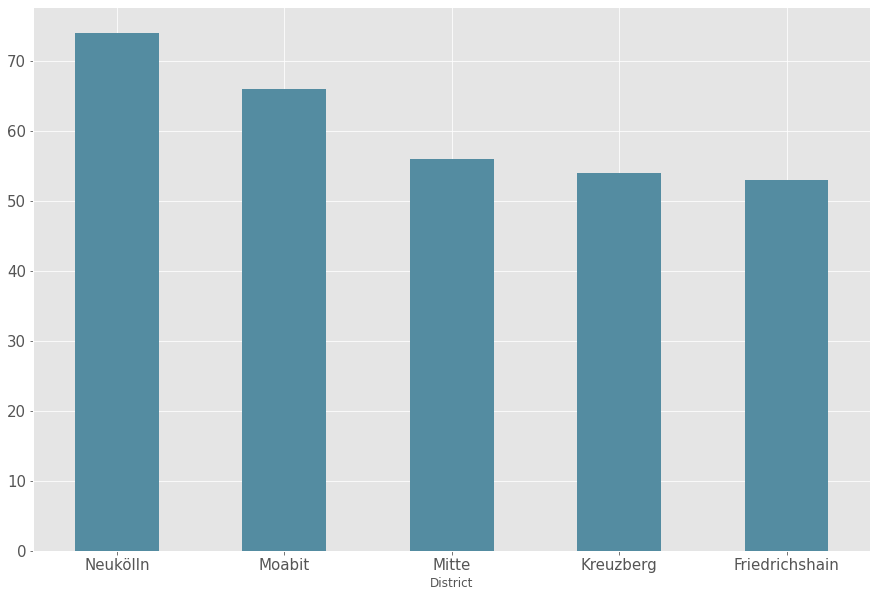

In [23]:
df = venues.head()
ax = df.plot.bar(figsize=(15, 10),rot=0, fontsize=15, color='#548ca1')

In [24]:
df_venuecount = venues.reset_index()
df_venuecount.columns = ['District','Number of Venues']
df_venuecount

,District,Number of Venues
0,Neukölln,74
1,Moabit,66
2,Mitte,56
3,Kreuzberg,54
4,Friedrichshain,53
...,...,...
90,Staaken,3
91,Falkenberg,3
92,Heiligensee,2
93,Rahnsdorf,1


Let's have a look at some categories

In [25]:
venues_df['VenueCategory'].unique()[:50]

array(['Outdoor Sculpture', 'Museum', 'Hotel', 'Scenic Lookout',
       'Neighborhood', 'Plaza', 'Garden', 'Cupcake Shop', 'Fountain',
       'Café', 'Bookstore', 'History Museum', 'Board Shop',
       'Cosmetics Shop', 'Restaurant', 'Art Museum', 'German Restaurant',
       'Outdoor Supply Store', 'Gourmet Shop', 'Sporting Goods Shop',
       'Spanish Restaurant', 'Art Gallery', 'Exhibit', 'Science Museum',
       'Brewery', 'Drugstore', 'Vietnamese Restaurant', 'Concert Hall',
       'Italian Restaurant', 'Costume Shop', 'Nightclub', 'Cocktail Bar',
       'Supermarket', 'French Restaurant', 'Taverna', 'Pub',
       'Trattoria/Osteria', 'Big Box Store', 'Food Court', 'Hostel',
       'Austrian Restaurant', 'Burger Joint', 'Bar', 'Grocery Store',
       'BBQ Joint', 'IT Services', 'Gym / Fitness Center',
       'Ice Cream Shop', 'Vegetarian / Vegan Restaurant',
       'Breakfast Spot'], dtype=object)

<h2>Identifying the most common venues in each district</h2>

In preparation the venues in each district are first dummy-coded.

In [26]:
# one hot encoding
berlin_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

In [27]:
berlin_onehot['District'] = venues_df['District'] 

In [28]:
berlin_onehot.head()

,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,Automotive Shop,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Windmill,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit,District
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Mitte
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Mitte
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Mitte
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Mitte
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Mitte


The District should be in the first column of the table

In [29]:
fixed_columns = list(berlin_onehot.columns[-1:]) + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

In [30]:
berlin_onehot.head()

,District,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Windmill,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Mitte,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
berlin_onehot.shape

(1430, 233)

Now we group the coded data set by District

In [32]:
berlin_grouped = berlin_onehot.groupby(["District"]).mean().reset_index()
berlin_grouped.head()

,District,ATM,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Austrian Restaurant,Auto Dealership,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Waterfront,Windmill,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Adlershof,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alt-Hohenschönhausen,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alt-Treptow,0.0,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,...,0.0,0.0,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Baumschulenweg,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Biesdorf,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
berlin_grouped.shape

(95, 233)

Now let's take a look at which 10 venues appear most often in each district.

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
count = []
for ind in np.arange(num_top_venues):
    try:
        count.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        count.append('{}th Most Common Venue'.format(ind+1))
columns = columns+count

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = berlin_grouped['District']


for ind in np.arange(berlin_grouped.shape[0]):
    row_categories = berlin_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    district_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(district_venues_sorted.shape)
district_venues_sorted

(95, 11)


,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,Gym,Plaza,Drugstore,Trattoria/Osteria,Italian Restaurant,Supermarket,Steakhouse,Greek Restaurant,Flower Shop,Fish Market
1,Alt-Hohenschönhausen,Supermarket,Tram Station,Asian Restaurant,Big Box Store,Drugstore,Greek Restaurant,Indian Restaurant,Food Court,Food Truck,Food & Drink Shop
2,Alt-Treptow,Café,Bakery,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Big Box Store,Tapas Restaurant,Gift Shop,Nightclub,Juice Bar
3,Baumschulenweg,Supermarket,Ice Cream Shop,Credit Union,Drugstore,Exhibit,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop
4,Biesdorf,Light Rail Station,Park,Bakery,Plaza,Supermarket,Palace,Big Box Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
90,Wilhelmsruh,Bus Stop,Bakery,Mexican Restaurant,Supermarket,Café,Lake,Clothing Store,Pharmacy,Drugstore,Eastern European Restaurant
91,Wilhelmstadt,Bus Stop,Harbor / Marina,Sporting Goods Shop,Supermarket,Bakery,Park,Lake,Boat or Ferry,Food Truck,Farmers Market
92,Wilmersdorf,Bakery,Supermarket,Hotel,French Restaurant,Burger Joint,Vietnamese Restaurant,Doner Restaurant,Italian Restaurant,Coffee Shop,Bus Stop
93,Wittenau,German Restaurant,Concert Hall,Italian Restaurant,Eastern European Restaurant,Restaurant,Park,Church,Metro Station,Fish Market,Falafel Restaurant


<h2>Clustering the districts acccording to their venue offer</h2>

The k means algorithm automatically clusters the neighborhoods based on their similarity in the most common venues. The algorithm is told to generate 6 categories.

In [35]:
# set number of clusters
kclusters = 6

berlin_grouped_clustering = berlin_grouped.drop(['District'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 2, 1, 1, 1, 4, 0, 1], dtype=int32)

Let's see the Cluster labels in our dataframe

In [36]:
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [37]:
district_venues_sorted

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Adlershof,Gym,Plaza,Drugstore,Trattoria/Osteria,Italian Restaurant,Supermarket,Steakhouse,Greek Restaurant,Flower Shop,Fish Market
1,0,Alt-Hohenschönhausen,Supermarket,Tram Station,Asian Restaurant,Big Box Store,Drugstore,Greek Restaurant,Indian Restaurant,Food Court,Food Truck,Food & Drink Shop
2,1,Alt-Treptow,Café,Bakery,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Big Box Store,Tapas Restaurant,Gift Shop,Nightclub,Juice Bar
3,2,Baumschulenweg,Supermarket,Ice Cream Shop,Credit Union,Drugstore,Exhibit,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop
4,1,Biesdorf,Light Rail Station,Park,Bakery,Plaza,Supermarket,Palace,Big Box Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
90,1,Wilhelmsruh,Bus Stop,Bakery,Mexican Restaurant,Supermarket,Café,Lake,Clothing Store,Pharmacy,Drugstore,Eastern European Restaurant
91,1,Wilhelmstadt,Bus Stop,Harbor / Marina,Sporting Goods Shop,Supermarket,Bakery,Park,Lake,Boat or Ferry,Food Truck,Farmers Market
92,1,Wilmersdorf,Bakery,Supermarket,Hotel,French Restaurant,Burger Joint,Vietnamese Restaurant,Doner Restaurant,Italian Restaurant,Coffee Shop,Bus Stop
93,1,Wittenau,German Restaurant,Concert Hall,Italian Restaurant,Eastern European Restaurant,Restaurant,Park,Church,Metro Station,Fish Market,Falafel Restaurant


In [38]:
district_venues_sorted.dtypes

Cluster Labels             int32
District                  object
1st Most Common Venue     object
2nd Most Common Venue     object
3rd Most Common Venue     object
4th Most Common Venue     object
5th Most Common Venue     object
6th Most Common Venue     object
7th Most Common Venue     object
8th Most Common Venue     object
9th Most Common Venue     object
10th Most Common Venue    object
dtype: object

In preparation to visualize our clusters on the map, we have to merge the dataframe with our coordinate data

In [39]:
berlin_merged = coord_data.copy()
berlin_merged.head()

,district,lat,long
0,Mitte,52.517885,13.404060
1,Moabit,52.530102,13.342542
2,Hansaviertel,52.519123,13.341872
3,Tiergarten,52.509778,13.357260
4,Wedding,52.550123,13.341970


In [40]:
berlin_merged.rename(columns={"district": "District"}, inplace=True)

In [41]:
berlin_merged = berlin_merged.merge(district_venues_sorted, on=['District'], how = 'right')
#df2 = pd.merge(df, trans, on=['key'], how='left')

print(berlin_merged.shape)

(95, 14)


In [42]:
berlin_merged.head()

,District,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,52.437893,13.547550,1,Gym,Plaza,Drugstore,Trattoria/Osteria,Italian Restaurant,Supermarket,Steakhouse,Greek Restaurant,Flower Shop,Fish Market
1,Alt-Hohenschönhausen,52.550409,13.502549,0,Supermarket,Tram Station,Asian Restaurant,Big Box Store,Drugstore,Greek Restaurant,Indian Restaurant,Food Court,Food Truck,Food & Drink Shop
2,Alt-Treptow,52.492563,13.459874,1,Café,Bakery,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Big Box Store,Tapas Restaurant,Gift Shop,Nightclub,Juice Bar
3,Baumschulenweg,52.461694,13.481548,2,Supermarket,Ice Cream Shop,Credit Union,Drugstore,Exhibit,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop
4,Biesdorf,52.510992,13.555013,1,Light Rail Station,Park,Bakery,Plaza,Supermarket,Palace,Big Box Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant


In [43]:
berlin_merged.dtypes

District                   object
lat                       float64
long                      float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

<h2>Visualization of the clusters on the map </h2>

In [44]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(berlin_merged['lat'], berlin_merged['long'], berlin_merged['District'], berlin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h2>Overview of the clusters</h2>

In the following we will create a table for each cluster to see which districts and venues belong to it

In [45]:
cluster_0 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(4, berlin_merged.shape[1]))]]
cluster_0

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alt-Hohenschönhausen,Supermarket,Tram Station,Asian Restaurant,Big Box Store,Drugstore,Greek Restaurant,Indian Restaurant,Food Court,Food Truck,Food & Drink Shop
8,Borsigwalde,Motorcycle Shop,Bakery,Mexican Restaurant,Supermarket,Italian Restaurant,Go Kart Track,Flower Shop,Fast Food Restaurant,Fish & Chips Shop,Fish Market
17,Fennpfuhl,Supermarket,Tram Station,Park,Department Store,Café,Construction & Landscaping,Drugstore,Italian Restaurant,Shipping Store,Pool
24,Gatow,Trattoria/Osteria,Bus Stop,Hotel,Italian Restaurant,Harbor / Marina,Supermarket,Zoo Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant
28,Grünau,Tram Station,Hotel,Snack Place,Dessert Shop,Restaurant,Historic Site,Massage Studio,Supermarket,Café,Zoo Exhibit
33,Heinersdorf,ATM,Supermarket,Tram Station,Fish Market,Discount Store,Chinese Restaurant,Insurance Office,Food Court,Exhibit,Flower Shop
49,Mahlsdorf,Automotive Shop,Platform,Tram Station,Italian Restaurant,Motorcycle Shop,Bakery,Supermarket,Light Rail Station,Gym / Fitness Center,Cosmetics Shop
53,Marzahn,Tram Station,Liquor Store,Windmill,Gas Station,Asian Restaurant,German Restaurant,Zoo Exhibit,Fish Market,Farmers Market,Fast Food Restaurant
61,Niederschönhausen,Tram Station,Thai Restaurant,Supermarket,Shipping Store,Hobby Shop,Dessert Shop,Bakery,Italian Restaurant,Park,Trattoria/Osteria
64,Pankow,Turkish Restaurant,Tram Station,Asian Restaurant,Zoo Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop


In [46]:
cluster_0.shape

(13, 11)

In [47]:
cluster_1 = berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[0] + list(range(4, berlin_merged.shape[1]))]]
cluster_1

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,Gym,Plaza,Drugstore,Trattoria/Osteria,Italian Restaurant,Supermarket,Steakhouse,Greek Restaurant,Flower Shop,Fish Market
2,Alt-Treptow,Café,Bakery,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Big Box Store,Tapas Restaurant,Gift Shop,Nightclub,Juice Bar
4,Biesdorf,Light Rail Station,Park,Bakery,Plaza,Supermarket,Palace,Big Box Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant
5,Blankenburg,Bus Stop,Café,Flower Shop,Greek Restaurant,Clothing Store,Zoo Exhibit,Farmers Market,French Restaurant,Fountain,Food Truck
6,Blankenfelde,Café,Bus Stop,Miscellaneous Shop,Zoo Exhibit,Furniture / Home Store,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop
9,Britz,Lake,History Museum,German Restaurant,Palace,Bus Stop,Bakery,Historic Site,Soccer Field,Hotel,Dive Bar
10,Buch,Drugstore,Bakery,Art Gallery,Italian Restaurant,Asian Restaurant,Big Box Store,Zoo Exhibit,Fish & Chips Shop,Fish Market,Flower Shop
12,Charlottenburg,Supermarket,Pizza Place,Chinese Restaurant,Café,Pool,Gourmet Shop,Bakery,Italian Restaurant,Hotel,Asian Restaurant
14,Dahlem,Park,Garden Center,German Restaurant,Zoo Exhibit,Exhibit,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop
15,Falkenberg,Nature Preserve,Café,Coffee Shop,Zoo Exhibit,Exhibit,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop


In [48]:
cluster_1.shape

(59, 11)

In [49]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[0] + list(range(4, berlin_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Baumschulenweg,Supermarket,Ice Cream Shop,Credit Union,Drugstore,Exhibit,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop
11,Buckow,Supermarket,Pizza Place,Miscellaneous Shop,Zoo Exhibit,Exhibit,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop
13,Charlottenburg-Nord,Supermarket,Rock Climbing Spot,Soccer Field,Bus Stop,Plaza,Post Office,Ethiopian Restaurant,Food & Drink Shop,Flower Shop,Fish Market
16,Falkenhagener Feld,Supermarket,Snack Place,Drugstore,Zoo Exhibit,Falafel Restaurant,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop
18,Französisch Buchholz,Supermarket,Flower Shop,Drugstore,Greek Restaurant,Zoo Exhibit,Falafel Restaurant,French Restaurant,Fountain,Food Truck,Food Court
31,Haselhorst,Bus Stop,Supermarket,Metro Station,Automotive Shop,Park,Zoo Exhibit,Falafel Restaurant,Fountain,Food Truck,Food Court
39,Kaulsdorf,Supermarket,Light Rail Station,Hotel,Plaza,Park,Fish & Chips Shop,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant
46,Lichtenrade,Soccer Field,Supermarket,Bus Stop,Doner Restaurant,Zoo Exhibit,Falafel Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop
51,Mariendorf,Supermarket,Metro Station,Steakhouse,Park,Greek Restaurant,Chinese Restaurant,Ice Cream Shop,Food & Drink Shop,Food Court,Food Truck
58,Neu-Hohenschönhausen,Supermarket,Movie Theater,Zoo Exhibit,Furniture / Home Store,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop


In [50]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 3, berlin_merged.columns[[0] + list(range(4, berlin_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Karow,Bus Stop,Supermarket,Health & Beauty Service,Restaurant,Zoo Exhibit,Exhibit,Fountain,Food Truck,Food Court,Food & Drink Shop
41,Konradshöhe,Bus Stop,Supermarket,Italian Restaurant,Restaurant,Zoo Exhibit,Exhibit,Fountain,Food Truck,Food Court,Food & Drink Shop
78,Staaken,Bus Stop,Restaurant,Eastern European Restaurant,Zoo Exhibit,Exhibit,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop
79,Stadtrandsiedlung Malchow,Bus Stop,Playground,Restaurant,Zoo Exhibit,Event Space,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop


In [51]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 4, berlin_merged.columns[[0] + list(range(4, berlin_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bohnsdorf,Bus Stop,Insurance Office,Italian Restaurant,Supermarket,Zoo Exhibit,Falafel Restaurant,French Restaurant,Fountain,Food Truck,Food Court
65,Plänterwald,Bus Stop,Supermarket,Light Rail Station,Zoo Exhibit,Furniture / Home Store,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop
67,Rahnsdorf,Bus Stop,Zoo Exhibit,Falafel Restaurant,Fried Chicken Joint,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Flower Shop


In [52]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 5, berlin_merged.columns[[0] + list(range(4, berlin_merged.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,Heiligensee,Insurance Office,Flower Shop,Zoo Exhibit,Event Space,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Fish Market
40,Kladow,Flower Shop,Zoo Exhibit,Exhibit,Fried Chicken Joint,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop,Fish Market


<h1>PART 2: Analysing if their is a significant relation between the boroughs' venue offer and corona incidence</h1>

Now that we have found out how many different venues there are in each district of Berlin and also clustered them according to their venue structure with the help of AI, the next interesting question is how these conditions relate to the incidence of covid infections.

Two hypotheses were formulated:

1) There is a positive correlation between the total number of venues in a borough and the incidence of covid infections.

2) There is a positive correlation between the number of "vibrant" clusters in a borough and the incidence of covid infections.

Unfortunately, the publicly available case numbers are currently only provided at borough level, not for each district. Therefore, adjustments to the data set were again necessary. The number of venues was cumulated at borough level and merged with the current dataset on corona infections in Berlin.


<h2>Accumulating data at borough level </h2>

For the subsequent study of the association with Corona infections, we need to summarize our results at Borough level. To do this, let's go back to our table from the beginning

In [73]:
berlin_boroughs

,Nr.,Ortsteil,Bezirk,Fläche(km²),Einwohner[2](31. Dezember 2019),Einwohnerpro km²
0,None,None,None,None,None,None
1,0101,Mitte,Mitte,"10,70",102.465,9576
2,0102,Moabit,Mitte,"7,72",80.495,10.427
3,0103,Hansaviertel,Mitte,"0,53",5.926,11.181
4,0104,Tiergarten,Mitte,"5,17",14.881,2878
...,...,...,...,...,...,...
93,1207,Waidmannslust,Reinickendorf,"2,30",10.973,4771
94,1208,Lübars,Reinickendorf,"5,00",5.203,1041
95,1209,Wittenau,Reinickendorf,"5,90",24.656,4179
96,1210,Märkisches Viertel,Reinickendorf,"3,20",40.379,12.618


We only need the districts and boroughs for the analysis

In [74]:
cols = [0,3,4,5]
berlin_boroughs.drop(berlin_boroughs.columns[cols],axis=1,inplace=True)

berlin_boroughs.columns = ['District','Borough']

berlin_boroughs

,District,Borough
0,None,None
1,Mitte,Mitte
2,Moabit,Mitte
3,Hansaviertel,Mitte
4,Tiergarten,Mitte
...,...,...
93,Waidmannslust,Reinickendorf
94,Lübars,Reinickendorf
95,Wittenau,Reinickendorf
96,Märkisches Viertel,Reinickendorf


Removing missing values

In [75]:
berlin_boroughs = berlin_boroughs[berlin_boroughs.District.notnull()]
berlin_boroughs.head()

,District,Borough
1,Mitte,Mitte
2,Moabit,Mitte
3,Hansaviertel,Mitte
4,Tiergarten,Mitte
5,Wedding,Mitte


Merging the dataframe with our "Number of Venues" data

In [76]:
berlin_df = berlin_boroughs.copy()

In [77]:
berlin_df = berlin_df.merge(df_venuecount, on=['District'], how = 'right')

In [78]:
berlin_df

,District,Borough,Number of Venues
0,Neukölln,Neukölln,74
1,Moabit,Mitte,66
2,Mitte,Mitte,56
3,Kreuzberg,Friedrichshain-Kreuzberg,54
4,Friedrichshain,Friedrichshain-Kreuzberg,53
...,...,...,...
90,Staaken,Spandau,3
91,Falkenberg,Lichtenberg,3
92,Heiligensee,Reinickendorf,2
93,Rahnsdorf,Treptow-Köpenick,1


<h2>Reading in data on corona incidence for each borough</h2>

The current Corona infection figures will be retrieved from the official capital portal of the city of Berlin 

In [79]:
covid_data = pd.read_csv('https://www.berlin.de/lageso/gesundheit/infektionsepidemiologie-infektionsschutz/corona/tabelle-bezirke/index.php/index/all.csv?q=', sep=';')
covid_data.head()

,id,bezirk,fallzahl,differenz,inzidenz,genesen
0,1,Charlottenburg-Wilmersdorf,7683,128,2236.1,6107
1,4,Friedrichshain-Kreuzberg,8534,117,2938.8,7244
2,7,Lichtenberg,5022,141,1707.0,3757
3,10,Marzahn-Hellersdorf,4425,96,1639.1,3355
4,13,Mitte,12487,356,3237.1,9120


Preprocessing the data

In [80]:
cols = [0,3,4,5]

covid_data.drop(covid_data.columns[cols],axis=1,inplace=True)


covid_data.columns = ['Borough','Infections']

covid_data
covid_data.shape

(13, 2)

In [81]:
covid_data = covid_data.drop([12], axis=0)

In [82]:
covid_data.shape

(12, 2)

Visualizing the data

In [83]:
df_graph = covid_data[['Borough','Infections']]
df_graph = df_graph.set_index('Borough')
df_graph = df_graph.sort_values(by=['Infections'], ascending = False)
df_graph.columns = ['Covid incidence in Berlin boroughs']

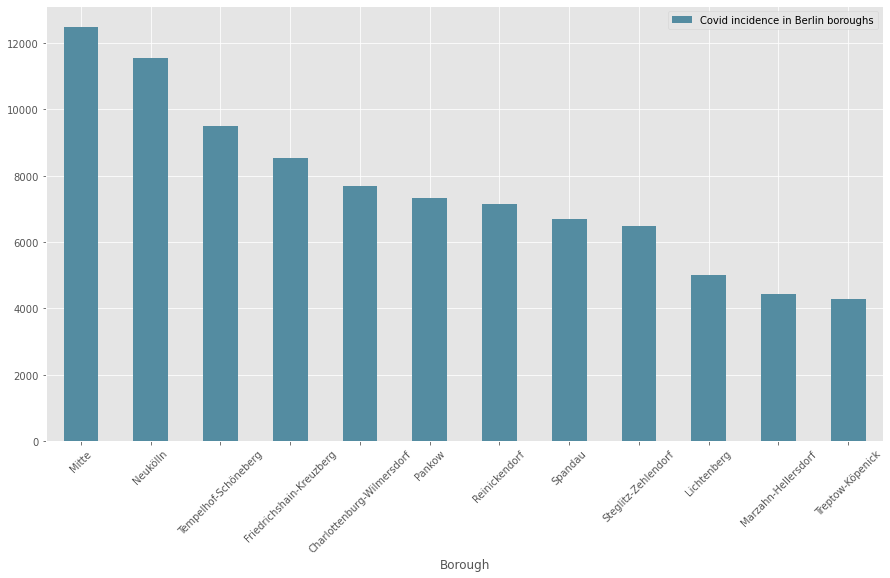

In [84]:
ax = df_graph.plot.bar(figsize=(15, 8), rot=45, fontsize=10, color='#548ca1')

<h2>Merging the infection rates with the number of venues</h2>

In [85]:
berlin_covid_df =  berlin_df.copy()

In [86]:
berlin_covid_df = berlin_covid_df.merge(covid_data, on=['Borough'], how = 'right')

print(berlin_covid_df.shape)

(95, 4)


In [87]:
berlin_covid_df

,District,Borough,Number of Venues,Infections
0,Wilmersdorf,Charlottenburg-Wilmersdorf,41,7683
1,Charlottenburg,Charlottenburg-Wilmersdorf,38,7683
2,Halensee,Charlottenburg-Wilmersdorf,34,7683
3,Schmargendorf,Charlottenburg-Wilmersdorf,22,7683
4,Grunewald,Charlottenburg-Wilmersdorf,15,7683
...,...,...,...,...
90,Müggelheim,Treptow-Köpenick,6,4278
91,Baumschulenweg,Treptow-Köpenick,5,4278
92,Plänterwald,Treptow-Köpenick,4,4278
93,Bohnsdorf,Treptow-Köpenick,4,4278


<h2>Merging the data with the venue clusters</h2>

Now we have to add our data on clusters and most common venues to the table in order to be able to analyse their impact

In [88]:
berlin_df = berlin_covid_df.merge(berlin_merged, on=['District'], how = 'right')



In [89]:
berlin_df

,District,Borough,Number of Venues,Infections,lat,long,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adlershof,Treptow-Köpenick,8,4278,52.437893,13.547550,1,Gym,Plaza,Drugstore,Trattoria/Osteria,Italian Restaurant,Supermarket,Steakhouse,Greek Restaurant,Flower Shop,Fish Market
1,Alt-Hohenschönhausen,Lichtenberg,9,5022,52.550409,13.502549,0,Supermarket,Tram Station,Asian Restaurant,Big Box Store,Drugstore,Greek Restaurant,Indian Restaurant,Food Court,Food Truck,Food & Drink Shop
2,Alt-Treptow,Treptow-Köpenick,27,4278,52.492563,13.459874,1,Café,Bakery,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,Big Box Store,Tapas Restaurant,Gift Shop,Nightclub,Juice Bar
3,Baumschulenweg,Treptow-Köpenick,5,4278,52.461694,13.481548,2,Supermarket,Ice Cream Shop,Credit Union,Drugstore,Exhibit,French Restaurant,Fountain,Food Truck,Food Court,Food & Drink Shop
4,Biesdorf,Marzahn-Hellersdorf,7,4425,52.510992,13.555013,1,Light Rail Station,Park,Bakery,Plaza,Supermarket,Palace,Big Box Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Wilhelmsruh,Pankow,10,7314,52.588012,13.362206,1,Bus Stop,Bakery,Mexican Restaurant,Supermarket,Café,Lake,Clothing Store,Pharmacy,Drugstore,Eastern European Restaurant
91,Wilhelmstadt,Spandau,11,6708,52.513921,13.191452,1,Bus Stop,Harbor / Marina,Sporting Goods Shop,Supermarket,Bakery,Park,Lake,Boat or Ferry,Food Truck,Farmers Market
92,Wilmersdorf,Charlottenburg-Wilmersdorf,41,7683,52.487115,13.320330,1,Bakery,Supermarket,Hotel,French Restaurant,Burger Joint,Vietnamese Restaurant,Doner Restaurant,Italian Restaurant,Coffee Shop,Bus Stop
93,Wittenau,Reinickendorf,9,7141,52.591237,13.323320,1,German Restaurant,Concert Hall,Italian Restaurant,Eastern European Restaurant,Restaurant,Park,Church,Metro Station,Fish Market,Falafel Restaurant


We actually don't need all of this info so let's slim the dataframe down again

In [90]:
cols = [4,5,7,8,9,10,11,12,13,14,15,16]
berlin_df.drop(berlin_df.columns[cols],axis=1,inplace=True)


berlin_df

,District,Borough,Number of Venues,Infections,Cluster Labels
0,Adlershof,Treptow-Köpenick,8,4278,1
1,Alt-Hohenschönhausen,Lichtenberg,9,5022,0
2,Alt-Treptow,Treptow-Köpenick,27,4278,1
3,Baumschulenweg,Treptow-Köpenick,5,4278,2
4,Biesdorf,Marzahn-Hellersdorf,7,4425,1
...,...,...,...,...,...
90,Wilhelmsruh,Pankow,10,7314,1
91,Wilhelmstadt,Spandau,11,6708,1
92,Wilmersdorf,Charlottenburg-Wilmersdorf,41,7683,1
93,Wittenau,Reinickendorf,9,7141,1


We can now count how often Cluster 1 ist represented in each borough

In [91]:
berlin_covid_df_grouped1 = (berlin_df.groupby(['Borough', 'Infections','Cluster Labels'])
         .apply(lambda x: (x['Cluster Labels']== 1).sum())
         .reset_index(name='count Clusters'))

In [92]:
berlin_covid_df_grouped1

,Borough,Infections,Cluster Labels,count Clusters
0,Charlottenburg-Wilmersdorf,7683,1,6
1,Charlottenburg-Wilmersdorf,7683,2,0
2,Friedrichshain-Kreuzberg,8534,1,2
3,Lichtenberg,5022,0,0
4,Lichtenberg,5022,1,6
5,Lichtenberg,5022,2,0
6,Marzahn-Hellersdorf,4425,0,0
7,Marzahn-Hellersdorf,4425,1,2
8,Marzahn-Hellersdorf,4425,2,0
9,Mitte,12487,0,0


In [93]:
berlin_covid_df_reduced = berlin_covid_df_grouped1.loc[berlin_covid_df_grouped1['Cluster Labels'] == 1]


In [94]:
berlin_covid_df_reduced

,Borough,Infections,Cluster Labels,count Clusters
0,Charlottenburg-Wilmersdorf,7683,1,6
2,Friedrichshain-Kreuzberg,8534,1,2
4,Lichtenberg,5022,1,6
7,Marzahn-Hellersdorf,4425,1,2
10,Mitte,12487,1,5
11,Neukölln,11563,1,3
14,Pankow,7314,1,6
18,Reinickendorf,7141,1,8
22,Spandau,6708,1,3
26,Steglitz-Zehlendorf,6477,1,6


Let's have a look at the number of Cluster1-districts in the boroughs

In [95]:
df_graph = berlin_covid_df_reduced[['Borough','count Clusters']]
df_graph = df_graph.set_index('Borough')
df_graph = df_graph.sort_values(by=['count Clusters'], ascending = False)
df_graph.columns = ['Number of Cluster 1 districts']



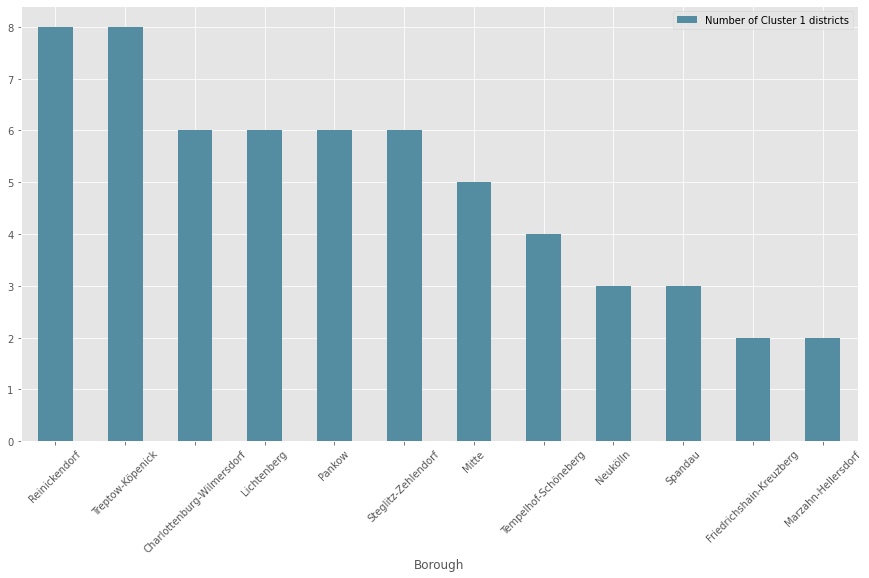

In [96]:

ax = df_graph.plot.bar(figsize=(15, 8), rot=45, fontsize=10, color='#548ca1')

<h2>Cumulating the number of venues at borough level</h2>

In [97]:
berlin_covid_df_grouped2 = berlin_df[['Borough', 'Number of Venues']]

In [98]:
berlin_covid_df_grouped2

,Borough,Number of Venues
0,Treptow-Köpenick,8
1,Lichtenberg,9
2,Treptow-Köpenick,27
3,Treptow-Köpenick,5
4,Marzahn-Hellersdorf,7
...,...,...
90,Pankow,10
91,Spandau,11
92,Charlottenburg-Wilmersdorf,41
93,Reinickendorf,9


In [99]:
berlin_covid_df_grouped2 = berlin_covid_df_grouped2.groupby(['Borough']).sum().reset_index()
berlin_covid_df_grouped2

,Borough,Number of Venues
0,Charlottenburg-Wilmersdorf,170
1,Friedrichshain-Kreuzberg,107
2,Lichtenberg,105
3,Marzahn-Hellersdorf,47
4,Mitte,219
5,Neukölln,104
6,Pankow,122
7,Reinickendorf,109
8,Spandau,84
9,Steglitz-Zehlendorf,99


<h2>Preparation for the statistical analysis</h2>

One final preprocessing step to get all our data in one dataframe

In [100]:
berlin_covid_df_grouped_both = berlin_covid_df_reduced.merge(berlin_covid_df_grouped2, on=['Borough'], how = 'right')

In [101]:
berlin_covid_df_grouped_both

,Borough,Infections,Cluster Labels,count Clusters,Number of Venues
0,Charlottenburg-Wilmersdorf,7683,1,6,170
1,Friedrichshain-Kreuzberg,8534,1,2,107
2,Lichtenberg,5022,1,6,105
3,Marzahn-Hellersdorf,4425,1,2,47
4,Mitte,12487,1,5,219
5,Neukölln,11563,1,3,104
6,Pankow,7314,1,6,122
7,Reinickendorf,7141,1,8,109
8,Spandau,6708,1,3,84
9,Steglitz-Zehlendorf,6477,1,6,99


Renaming the columns to make them easier accessable 

In [102]:
berlin_covid_dataframe = berlin_covid_df_grouped_both

berlin_covid_dataframe.columns = ['borough','infections','cluster','clustercount','venuenum']
berlin_covid_dataframe



,borough,infections,cluster,clustercount,venuenum
0,Charlottenburg-Wilmersdorf,7683,1,6,170
1,Friedrichshain-Kreuzberg,8534,1,2,107
2,Lichtenberg,5022,1,6,105
3,Marzahn-Hellersdorf,4425,1,2,47
4,Mitte,12487,1,5,219
5,Neukölln,11563,1,3,104
6,Pankow,7314,1,6,122
7,Reinickendorf,7141,1,8,109
8,Spandau,6708,1,3,84
9,Steglitz-Zehlendorf,6477,1,6,99


Checking if the datatypes are right

In [103]:
berlin_covid_dataframe.dtypes

borough         object
infections       int64
cluster          int64
clustercount     int64
venuenum         int64
dtype: object

Importing libraries for statistical analysis

In [104]:

from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

Now we'll check with the help of scatterplots if these give us a hint on any linear relationship between our variables

Scatterplot 1: Relationship between x=number of Cluster1-Venues and y=covid incidence

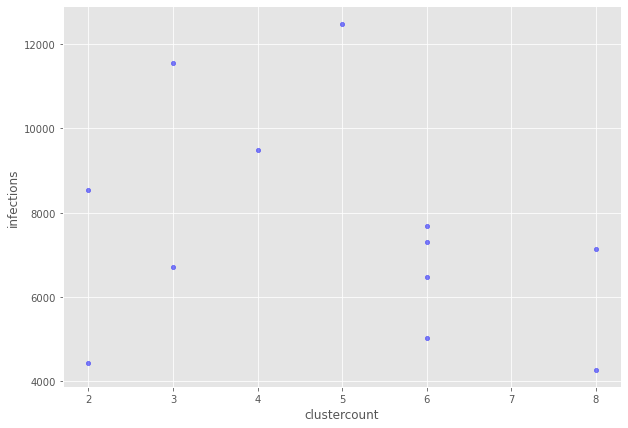

In [105]:
ax1 = berlin_covid_dataframe.plot(kind='scatter', x='clustercount', y='infections', color='blue', alpha=0.5, figsize=(10, 7))


Scatterplot 2: Relationship between x=total number of venues and y=covid incidence

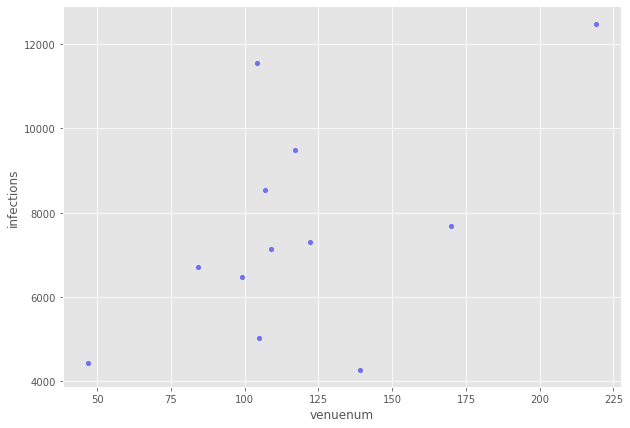

In [106]:
ax1 = berlin_covid_dataframe.plot(kind='scatter', x='venuenum', y='infections', color='blue', alpha=0.5, figsize=(10, 7))

We also need to see if the residuals are reasonably equally distributed, as a prerequisite for performing a regression analysis.

Residual Plot 1 for x=number of Cluster1-Districts and their relation to y=covid incidence

<AxesSubplot:xlabel='clustercount', ylabel='infections'>

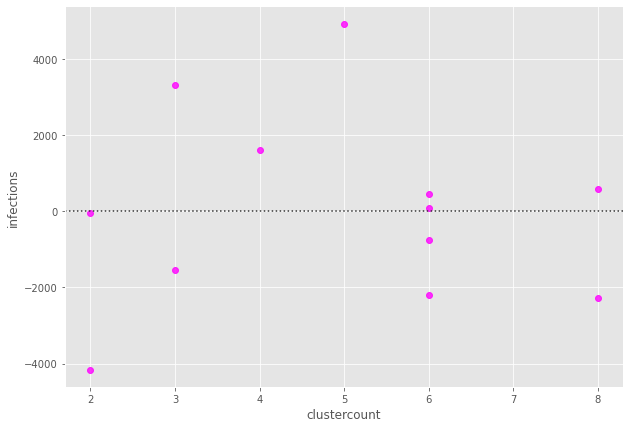

In [107]:
# residual plot
fig = plt.figure(figsize = (10, 7))
sns.residplot(berlin_covid_dataframe.clustercount, berlin_covid_dataframe.infections, color='magenta')



Residual Plot 1 for x=total number of venues and their relation to y=covid incidence

<AxesSubplot:xlabel='venuenum', ylabel='infections'>

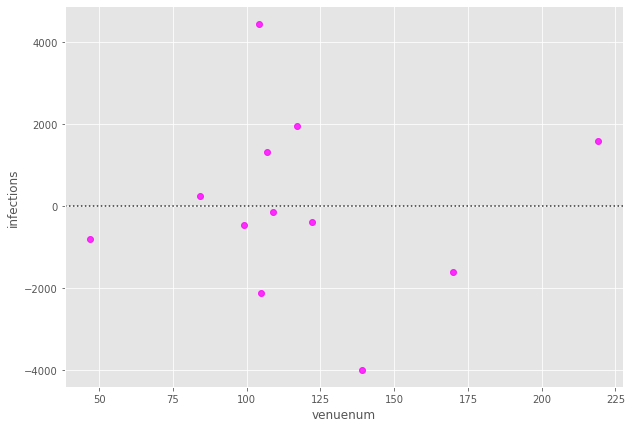

In [108]:
# residual plot
fig = plt.figure(figsize = (10, 7))
sns.residplot(berlin_covid_dataframe.venuenum, berlin_covid_dataframe.infections, color='magenta')

<h2>Fitting the regression model to check for a significant relationship between Venues and Covid</h2>

Hypothese 1: There is a positive correlation between the total number of venues in a borough and the incidence of covid infections.

In [109]:
import statsmodels.api as sm

In [110]:
X = berlin_covid_dataframe['clustercount']
#X = berlin_covid_dataframe['venuenum']# here we have 2 variables for the multiple linear regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example
Y = berlin_covid_dataframe['infections']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             infections   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.8184
Date:                Wed, 23 Dec 2020   Prob (F-statistic):              0.387
Time:                        17:58:43   Log-Likelihood:                -110.38
No. Observations:                  12   AIC:                             224.8
Df Residuals:                      10   BIC:                             225.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9259.0920   1989.812      4.653   

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


Hypothese 2: There is a positive correlation between the number of "vibrant" clusters in a borough and the incidence of covid infections.

In [111]:
#X = berlin_covid_dataframe['clustercount']
X = berlin_covid_dataframe['venuenum']# here we have 2 variables for the multiple linear regression. If you just want to use one variable for simple linear regression, then use X = df['Interest_Rate'] for example
Y = berlin_covid_dataframe['infections']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:             infections   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     4.267
Date:                Wed, 23 Dec 2020   Prob (F-statistic):             0.0658
Time:                        17:58:44   Log-Likelihood:                -108.72
No. Observations:                  12   AIC:                             221.4
Df Residuals:                      10   BIC:                             222.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3694.3353   1999.198      1.848      0.0

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


The number of cluster 1 districts was found to have no significant effect on the corona incidence in a region (p = .38, alpha = .05). The number of venues in a region also did not have the expected effect: more venues in a borough does not necessarily result in more infections with the virus (p=.06, alpha = .05) even though a slight trend is evident in the data. 

Thus, the results of this analysis do not suggest that the differences in the risk of contagion between boroughs can be related to their specific mix of venue offerings. 

Obviously, there are several limitations to this analysis. First, the size and population density of the districts under consideration were not taken into account, which are certainly decisive factors. Second, with the cumulative numbers, there were not that many data points available to feed into the regression analysis, resulting in a limited validity of the results. In addition, most venues had been locked-down for months anyway, making it hard to detect their influence. Most infections currently occur at private gatherings, the frequency of which is not recorded in any statistics.


Nevertheless, this exercise has hopefully demonstrated an interesting approach to the topic and could possibly be applied in a similar way to other cities. The project mainly served to consolidate my new data science skills acquired through the IBM Data Science course and I certainly had fun doing it. 

<h1>Thanks, bye :)</h1>